In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import warnings
import os

# Suppress warnings
warnings.filterwarnings('ignore')

# --- PATH CONFIGURATION ---
BASE_DIR = Path("./PS2-SIH25").resolve()
DATA_DIR = BASE_DIR / "Data_SIH_2025 2"
ARTIFACT_DIR = Path("artifacts/xgb_models-2.0")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# --- MODEL CONFIGURATION ---
TARGETS = ['O3_target', 'NO2_target']
LAGS = [1, 2, 3, 6, 12, 24]

FORECAST_FEATURES = [
    'O3_forecast', 'NO2_forecast', 'T_forecast', 'q_forecast',
    'u_forecast', 'v_forecast', 'w_forecast'
]

XGB_PARAMS = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'early_stopping_rounds': 50,
    'random_state': 42
}

print("✅ Configuration Loaded.")
print(f"📂 Data Directory: {DATA_DIR}")
print(f"📂 Artifacts Directory: {ARTIFACT_DIR}")

✅ Configuration Loaded.
📂 Data Directory: /content/PS2-SIH25/Data_SIH_2025 2
📂 Artifacts Directory: artifacts/xgb_models-2.0


In [2]:
def create_lag_features(df, targets, lags):
    """Creates lagged features for the target variables."""
    df_lagged = df.copy()
    for target in targets:
        for lag in lags:
            df_lagged[f'{target}_lag_{lag}'] = df_lagged[target].shift(lag)
    return df_lagged

def R2_SAFE(r2):
    """Clamps R2 to -1.0 to prevent massive negative numbers in reporting."""
    if r2 < -1.0: return -1.0
    return r2

def calculate_metrics(y_true, y_pred, site_name, target_name):
    """Calculates comprehensive regression metrics."""
    return {
        'Site': site_name,
        'Target': target_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': R2_SAFE(r2_score(y_true, y_pred)),
        'Bias': np.mean(y_pred - y_true)
    }

print("✅ Helper Functions Defined.")

✅ Helper Functions Defined.


STARTING TRAINING PIPELINE (ZOOMED-IN PLOTS)

📍 PROCESSING SITE 1
   ------------------------------------------------
   [1] Train: 20045 | Test: 5012
       > Target: O3_target    | R2: 0.9450
       > Target: NO2_target   | R2: 0.8467


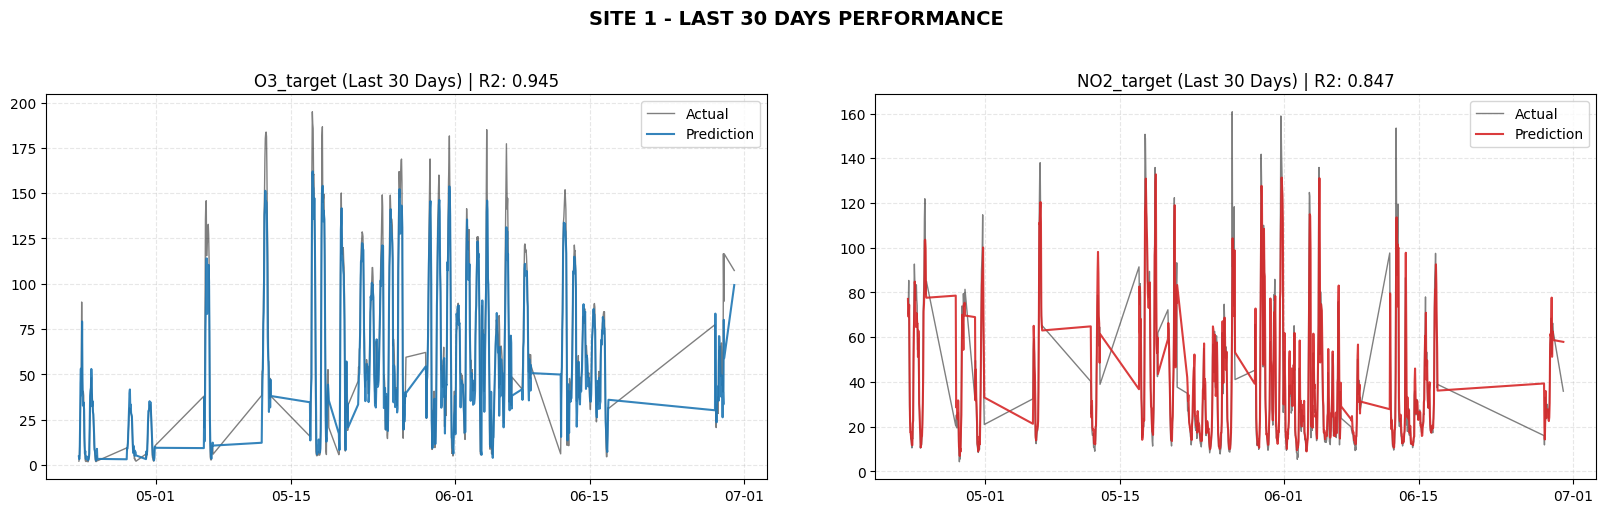



📍 PROCESSING SITE 2
   ------------------------------------------------
   [1] Train: 20756 | Test: 5189
       > Target: O3_target    | R2: 0.9159
       > Target: NO2_target   | R2: 0.8621


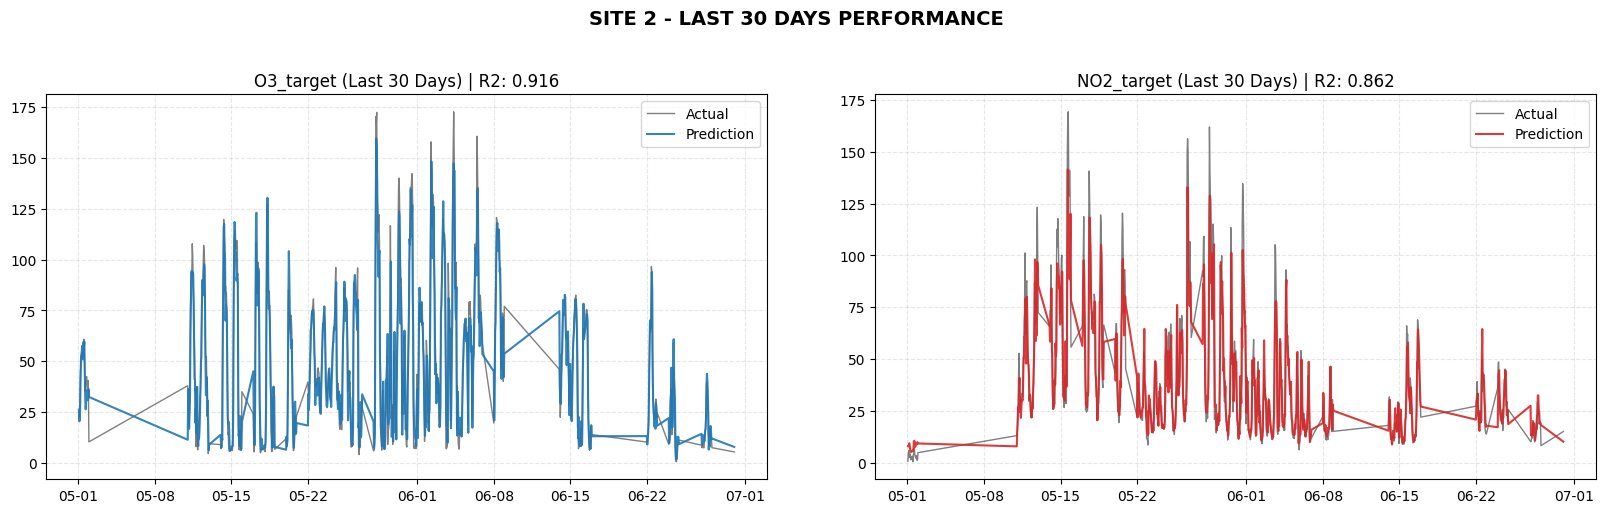



📍 PROCESSING SITE 3
   ------------------------------------------------
   [1] Train: 17511 | Test: 4378
       > Target: O3_target    | R2: 0.9186
       > Target: NO2_target   | R2: 0.8797


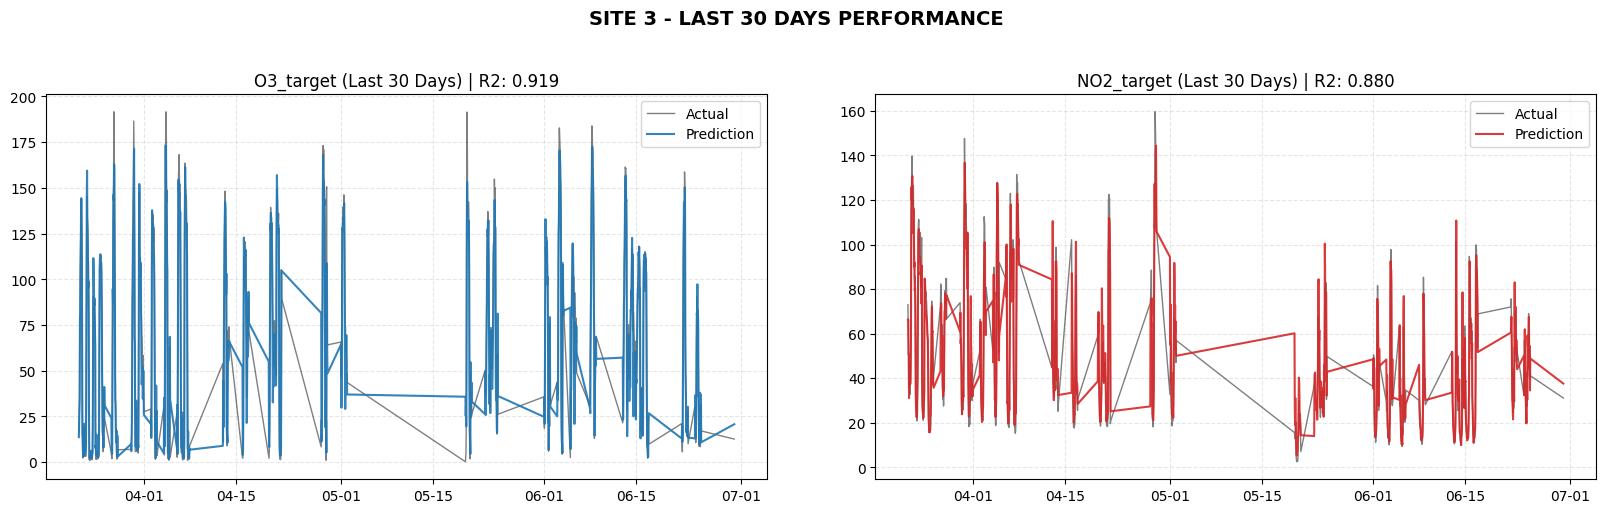



📍 PROCESSING SITE 4
   ------------------------------------------------
   [1] Train: 19584 | Test: 4897
       > Target: O3_target    | R2: 0.9374
       > Target: NO2_target   | R2: 0.8337


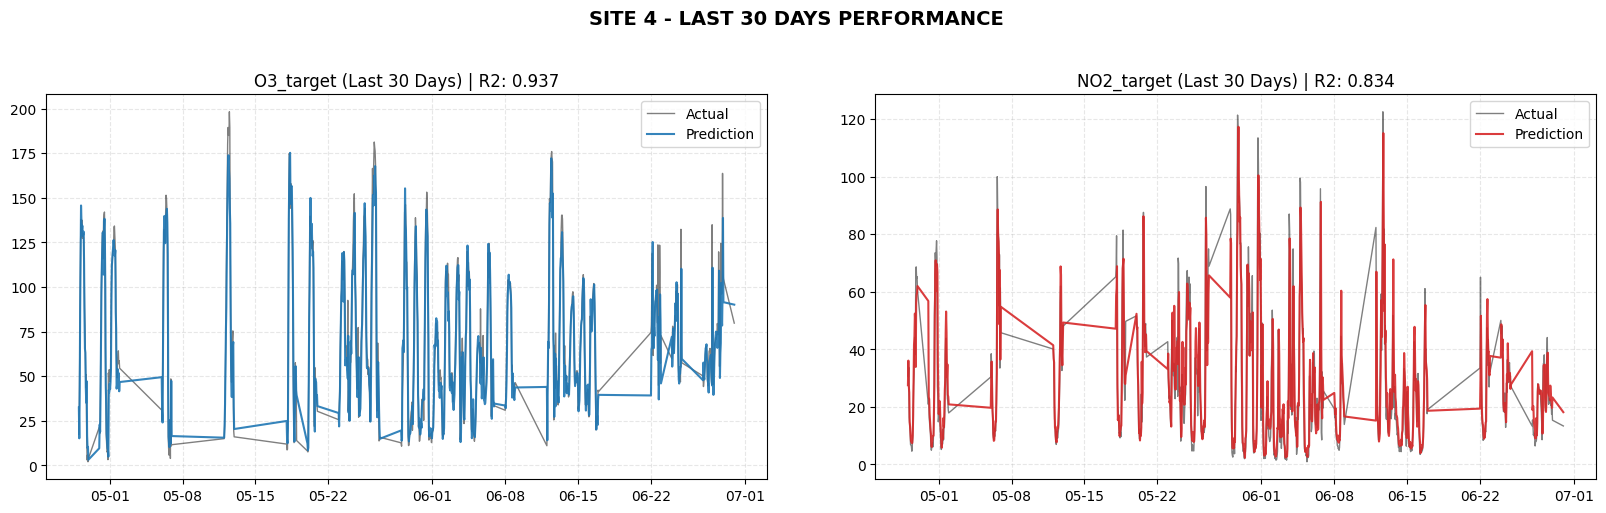



📍 PROCESSING SITE 5
   ------------------------------------------------
   [1] Train: 20045 | Test: 5012
       > Target: O3_target    | R2: 0.9259
       > Target: NO2_target   | R2: 0.8921


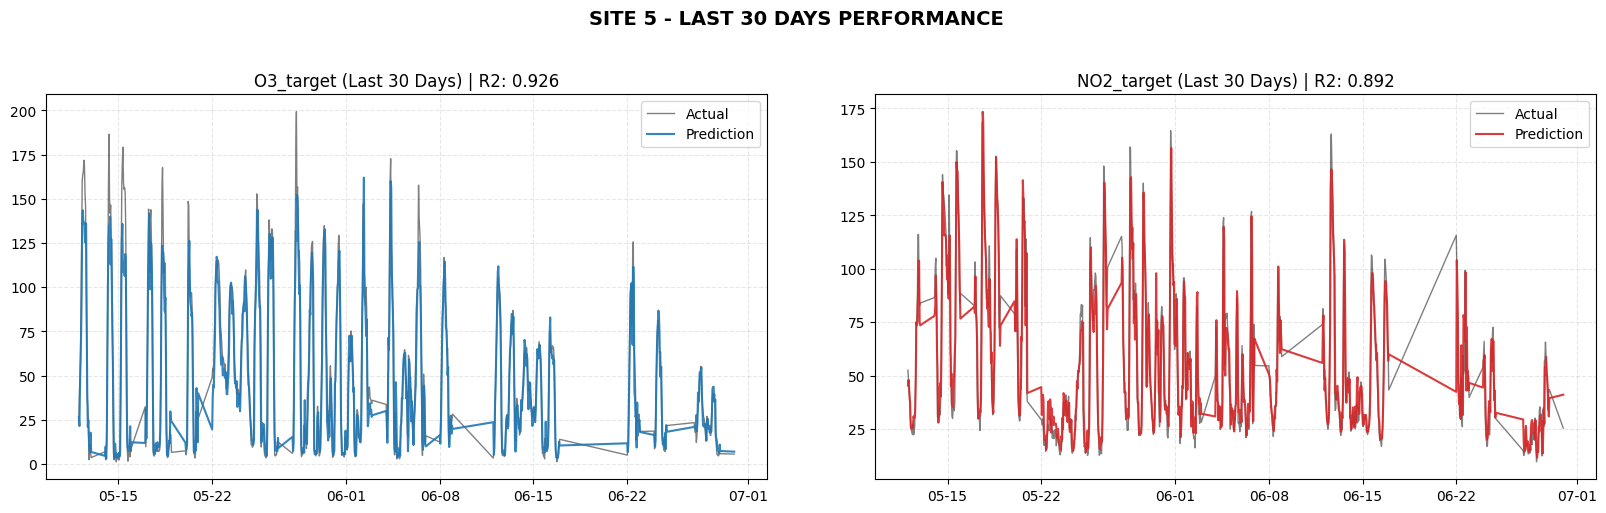



📍 PROCESSING SITE 6
   ------------------------------------------------
   [1] Train: 21063 | Test: 5266
       > Target: O3_target    | R2: 0.7760
       > Target: NO2_target   | R2: 0.7917


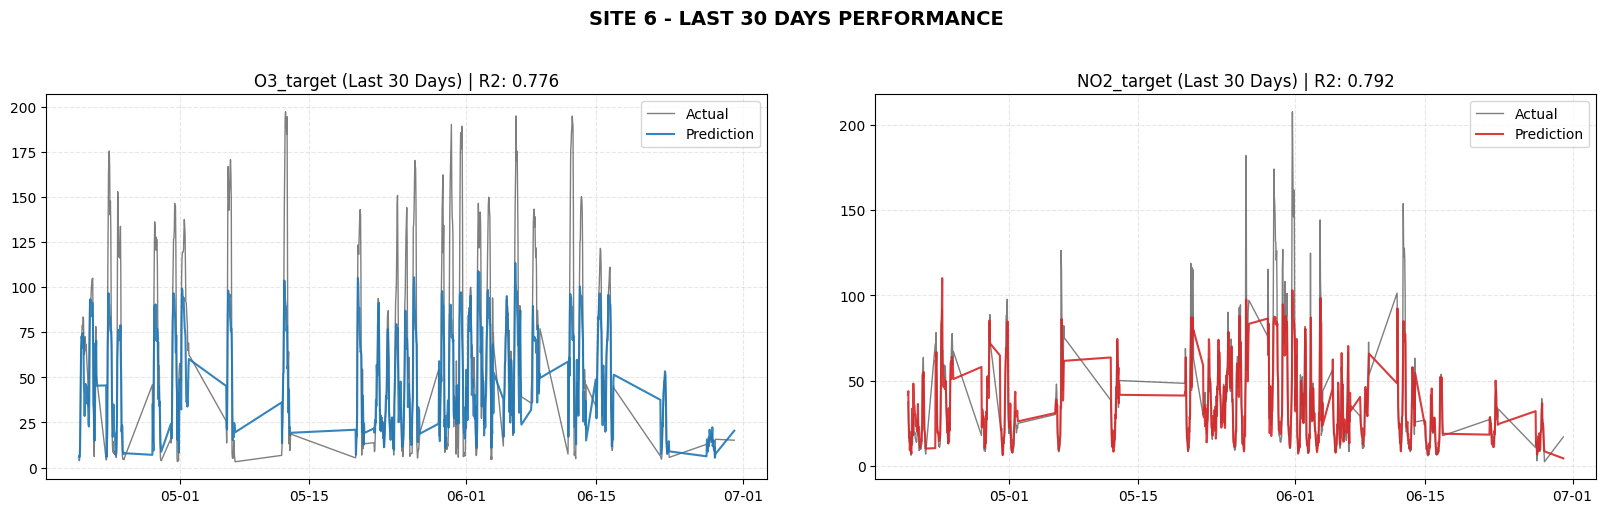



📍 PROCESSING SITE 7
   ------------------------------------------------
   [1] Train: 18202 | Test: 4551
       > Target: O3_target    | R2: 0.9254
       > Target: NO2_target   | R2: 0.8567


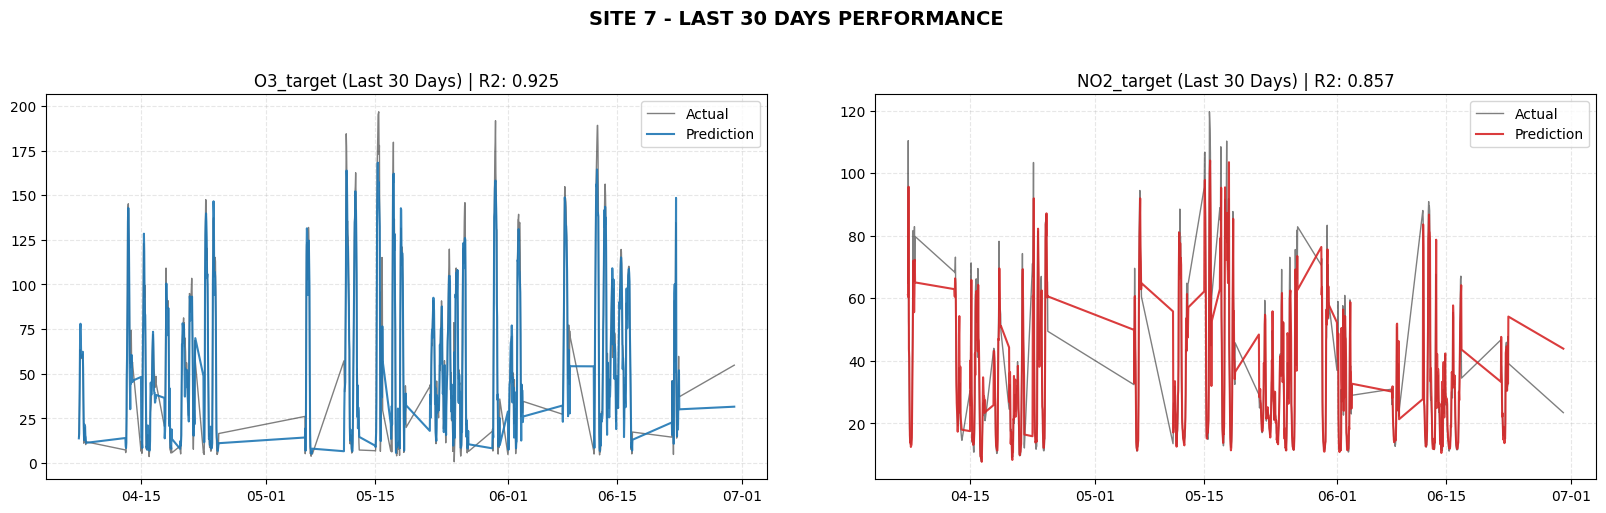

In [12]:
# List to store results for final summary
all_metrics = []

print(f"{'='*100}")
print("STARTING TRAINING PIPELINE (ZOOMED-IN PLOTS)")
print(f"{'='*100}\n")

# ITERATE THROUGH SITES
for site_id in range(1, 8):

    # ---------------------------------------------------------
    # 1. DATA LOADING
    # ---------------------------------------------------------
    file_path = DATA_DIR / f"site_{site_id}_train_data.csv"
    if not file_path.exists():
        print(f"⚠️ Skipping Site {site_id} (File not found)")
        continue

    df = pd.read_csv(file_path)
    print(f"📍 PROCESSING SITE {site_id}")
    print(f"   ------------------------------------------------")

    # ---------------------------------------------------------
    # 2. PREPROCESSING
    # ---------------------------------------------------------
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    df = df.sort_values('datetime').reset_index(drop=True)

    # Interpolate Forecast cols
    forecast_cols = ['NO2_forecast', 'O3_forecast', 'T_forecast', 'q_forecast', 'u_forecast', 'v_forecast', 'w_forecast']
    for col in forecast_cols:
        if col in df.columns:
            df[col] = df[col].interpolate(method='linear', limit_direction='both')

    # Create Lags
    df_processed = create_lag_features(df, TARGETS, LAGS)

    # ---------------------------------------------------------
    # 3. SURGICAL DROP
    # ---------------------------------------------------------
    cols_to_check = TARGETS + [c for c in df_processed.columns if 'lag' in c] + FORECAST_FEATURES
    df_processed = df_processed.dropna(subset=cols_to_check).reset_index(drop=True)

    # ---------------------------------------------------------
    # 4. TRAIN/TEST SPLIT
    # ---------------------------------------------------------
    train_size = int(len(df_processed) * 0.80)
    train_df = df_processed.iloc[:train_size]
    test_df = df_processed.iloc[train_size:]

    print(f"   [1] Train: {len(train_df)} | Test: {len(test_df)}")

    # Prepare Plotting Area
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    plt.subplots_adjust(wspace=0.15)
    fig.suptitle(f"SITE {site_id} - LAST 30 DAYS PERFORMANCE", fontsize=14, fontweight='bold', y=1.05)

    # ---------------------------------------------------------
    # 5. TRAINING LOOP
    # ---------------------------------------------------------
    for idx, target in enumerate(TARGETS):
        feature_cols = FORECAST_FEATURES + [col for col in df_processed.columns if 'lag' in col]

        # Train
        model = xgb.XGBRegressor(**XGB_PARAMS)

        # --- FIX: Added eval_set back so early_stopping works ---
        model.fit(
            train_df[feature_cols], train_df[target],
            eval_set=[(test_df[feature_cols], test_df[target])], # <--- THE FIX
            verbose=False
        )

        # Predict
        y_pred = model.predict(test_df[feature_cols])

        # Metrics
        m = calculate_metrics(test_df[target], y_pred, f"site_{site_id}", target)
        all_metrics.append(m)
        print(f"       > Target: {target:<12} | R2: {m['R2']:.4f}")

        # Save
        model.save_model(ARTIFACT_DIR / f"site_{site_id}_{target}_xgb.json")

        # --- CLEAN PLOTTING (ZOOMED IN) ---
        ax = axes[idx]

        # ZOOM: Only take the last 720 hours (30 days) for plotting
        zoom_hours = 720
        if len(test_df) > zoom_hours:
            plot_dates = test_df['datetime'].iloc[-zoom_hours:]
            plot_true = test_df[target].iloc[-zoom_hours:]
            plot_pred = y_pred[-zoom_hours:]
            title_suffix = "(Last 30 Days)"
        else:
            plot_dates = test_df['datetime']
            plot_true = test_df[target]
            plot_pred = y_pred
            title_suffix = "(Full Test Set)"

        # Plot Actual (Grey/Black, thinner)
        ax.plot(plot_dates, plot_true, color='black', alpha=0.5, label='Actual', linewidth=1)

        # Plot Pred (Bright Color, slightly thicker)
        color = '#d62728' if 'NO2' in target else '#1f77b4'
        ax.plot(plot_dates, plot_pred, color=color, alpha=0.9, label='Prediction', linewidth=1.5)

        ax.set_title(f"{target} {title_suffix} | R2: {m['R2']:.3f}")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
        ax.legend(loc='upper right')
        ax.grid(alpha=0.3, linestyle='--')

    plt.show()
    print("\n")

In [13]:
results_df = pd.DataFrame(all_metrics)

print(f"{'='*80}")
print("FINAL SUMMARY REPORT")
print(f"{'='*80}")
print(results_df.round(4).to_string(index=False))

print(f"\n{'='*80}")
print("AVERAGE METRICS ACROSS ALL 7 SITES")
print(f"{'='*80}")

# Group by Target and calculate mean of numeric columns
avg_metrics = results_df.groupby('Target')[['R2', 'MAE', 'RMSE', 'Bias']].mean().reset_index()
print(avg_metrics.round(4).to_string(index=False))

# Save to CSV
results_df.to_csv(ARTIFACT_DIR / "final_metrics_report.csv", index=False)
avg_metrics.to_csv(ARTIFACT_DIR / "average_metrics_summary.csv", index=False)
print(f"\n📄 Reports saved to: {ARTIFACT_DIR}")

FINAL SUMMARY REPORT
  Site     Target    MAE    RMSE     R2    Bias
site_1  O3_target 2.7865  6.4289 0.9450 -0.0436
site_1 NO2_target 5.5906 10.4547 0.8467 -0.5699
site_2  O3_target 4.5051  7.7291 0.9159  0.2924
site_2 NO2_target 5.2099  8.1960 0.8621 -0.1241
site_3  O3_target 6.7448 11.0174 0.9186 -0.1264
site_3 NO2_target 6.5799 10.2754 0.8797  0.9153
site_4  O3_target 5.8233  9.4222 0.9374 -0.6204
site_4 NO2_target 4.8463  7.7041 0.8337  0.3207
site_5  O3_target 5.6949  9.1511 0.9259 -0.6604
site_5 NO2_target 8.0725 13.5341 0.8921 -1.0695
site_6  O3_target 9.0548 17.3328 0.7760 -3.0633
site_6 NO2_target 5.8939 10.2688 0.7917 -0.6849
site_7  O3_target 6.0339  9.6863 0.9254  0.1099
site_7 NO2_target 4.3155  7.5299 0.8567 -0.0562

AVERAGE METRICS ACROSS ALL 7 SITES
    Target     R2    MAE    RMSE    Bias
NO2_target 0.8518 5.7870  9.7090 -0.1812
 O3_target 0.9063 5.8062 10.1097 -0.5874

📄 Reports saved to: artifacts/xgb_models-2.0
